In [1]:
from utils.libs import *

In [2]:
n_hf, n_hl = 64, 5
w, h = 256, 256
baseline_values_ws = "128,4096,4096,4096,4096,4096,64".split(",")
baseline_values_ws = list(map(float, baseline_values_ws))

tot_ws_baseline = sum(baseline_values_ws)
print('Tot number weigths', tot_ws_baseline)

baseline_values_bias = "2,64,64,64,64,64,1".split(",")
baseline_values_bias = list(map(float, baseline_values_bias))

tot_bias_baseline = sum(baseline_values_bias)
print('Tot number biases', tot_bias_baseline)

baseline_model_size_bit = (tot_bias_baseline + tot_ws_baseline) * 32
print("Baseline(Byte)", baseline_model_size_bit / 8, "Baseline(bit)", baseline_model_size_bit )

Tot number weigths 20672.0
Tot number biases 323.0
Baseline(Byte) 83980.0 Baseline(bit) 671840.0


Image size: (512, 512)


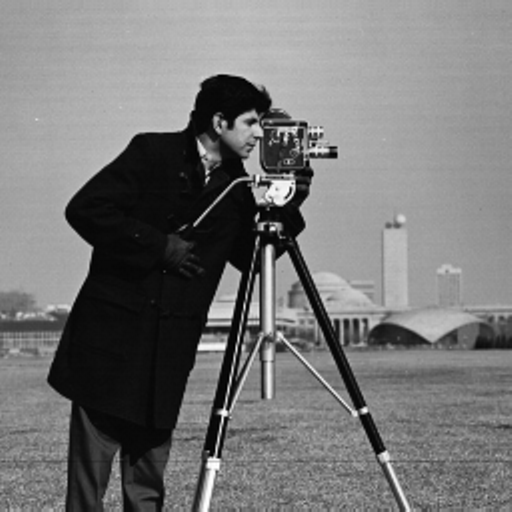

In [3]:
# --- Load target image.
im = load_target_image(image_file_path = None)
print('Image size:', im.size)
im

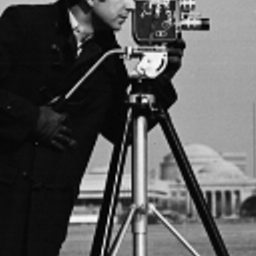

In [4]:
crop_size = (256,256)
im_cropped = get_cropped_by_center_image(im, target = crop_size)
im_cropped

In [5]:
cropped_file_size_bits = None
with BytesIO() as f:
    im_cropped.save(f, format='PNG')
    cropped_file_size_bits = f.getbuffer().nbytes * 8
    pass

In [6]:
train_df = load_data_baseline(im_cropped)
train_df.head(5)

SELECT image,date,timestamp,hidden_features,image_size,status,data_downloaded FROM table_runs_logged WHERE   (image = 'cameramen') AND (image_size = '[256,256]')  AND (status = 'done') ;
Error: file 'D:\data\data_thesys\cameramen\07-11-2020\1604779421-808068\train\result_comb_train.txt' does not exists!


,#params,seed,hl,hf,mse,psnr,ssim,eta,file_size_bits,CR,bpp,compression
1603478755-305517,57301.0,0.0,10.0,75.0,0.000006,58.145780,0.998769,2688.703879,1833632.0,0.138523,27.979004,siren-75
1603478755-305517,57301.0,42.0,10.0,75.0,0.000009,56.492704,0.998202,2690.827056,1833632.0,0.138523,27.979004,siren-75
1603478755-305517,57301.0,123.0,10.0,75.0,0.000006,58.214385,0.999085,2686.608420,1833632.0,0.138523,27.979004,siren-75
1603478755-305517,63001.0,0.0,11.0,75.0,0.000018,53.486111,0.997542,2904.513145,2016032.0,0.125990,30.762207,siren-75
1603478755-305517,63001.0,42.0,11.0,75.0,0.000005,58.401365,0.999003,2906.302068,2016032.0,0.125990,30.762207,siren-75


In [7]:
result_jpeg_df = load_jpeg_baseline(im_cropped)
result_jpeg_df.head(5)

,mse,psnr,ssim,quality,file_size_bits,bpp,width,heigth,CR,compression
0,30.618301,33.270993,0.939424,20,33064,0.504517,256,256,7.682071,jpeg
1,28.949783,33.514350,0.940436,21,33968,0.518311,256,256,7.477626,jpeg
2,27.839966,33.684117,0.941620,22,34736,0.530029,256,256,7.312298,jpeg
3,26.316681,33.928492,0.944786,23,35408,0.540283,256,256,7.173520,jpeg
4,25.208344,34.115361,0.946817,24,36000,0.549316,256,256,7.055556,jpeg


In [8]:
data_pr_df, data_ps_df = load_agp_dataframe()

Read from agp_prune_rate_test.txt # rows: 27
Read from test_agp_data.txt # rows: 28


In [9]:
df = pd.DataFrame()
mse = data_ps_df["Mse"].values
ssim = data_ps_df["Ssim (%)"].values
psnr = data_ps_df["Psnr (db)"].values
bpp = data_ps_df["Bpp"].values
file_size_bits = data_ps_df["Footprint (Byte)"].values * 32
CR = cropped_file_size_bits / (file_size_bits)

df['mse'] = mse
df['ssim'] = ssim
df['psnr'] = psnr
df['file_size_bits'] = file_size_bits
df['CR'] = CR
df['bpp'] = bpp
df['weights'] = data_ps_df["Footprint (Byte)"].values

def map_2_compression(a_data, tot_ws_baseline=tot_ws_baseline):
    return 'agp-siren' +  '-' + str(int(np.ceil(100 - a_data/ tot_ws_baseline * 100)))
    
df['compression'] = list(map(map_2_compression, data_ps_df["Footprint (Byte)"].values))


agp_df = df
agp_df.head(5)

,mse,ssim,psnr,file_size_bits,CR,bpp,weights,compression
0,0.000105,0.989299,45.815070,416320.0,0.610108,6.352539,13010.0,agp-siren-38
1,0.000119,0.988715,45.284305,416288.0,0.610155,6.352051,13009.0,agp-siren-38
2,0.000133,0.990356,44.789306,455616.0,0.557487,6.952148,14238.0,agp-siren-32
3,0.000122,0.990075,45.153248,455616.0,0.557487,6.952148,14238.0,agp-siren-32
4,0.000115,0.990626,45.418737,462240.0,0.549498,7.053223,14445.0,agp-siren-31


In [10]:
train_df_columns_for_merge = "psnr,ssim,CR,bpp,file_size_bits,compression".split(",")
result_jpeg_df_columns_for_merge = "psnr,ssim,CR,bpp,file_size_bits,compression".split(",")

data_frames_list = [
    train_df[train_df_columns_for_merge],
    result_jpeg_df[result_jpeg_df_columns_for_merge],
]
merged_df = pd.concat(data_frames_list, names = "psnr,ssim,CR,bpp,file_size_bits,compression".split(","))

In [11]:
net_layers = list(filter(lambda xx: xx.startswith("net"), data_pr_df.columns))
pprint(net_layers)

['net.0.linear',
 'net.1.linear',
 'net.2.linear',
 'net.3.linear',
 'net.4.linear',
 'net.5.linear',
 'net.6']


In [12]:
siren_quant_aware_df = load_siren_quant_aware_data_df(net_layers, w, h, cropped_file_size_bits)

In [13]:
siren_quant_aware_df.describe()

,MSE,PSNR,SSIM,TIME,FREQ_UPDT,BITS_WTS,lr,model_size_byte,bpp,CR
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.0,20.000000,20.0,20.000000,2.000000e+01
mean,0.002112,34.324304,0.915845,0.007888,7.000000,8.0,0.000055,14064.0,1.716797,2.257537e+00
std,0.001630,3.958845,0.048001,0.000094,2.513123,0.0,0.000046,0.0,0.000000,4.556259e-16
min,0.000445,29.294963,0.853901,0.007772,5.000000,8.0,0.000010,14064.0,1.716797,2.257537e+00
25%,0.000685,31.165942,0.873913,0.007813,5.000000,8.0,0.000010,14064.0,1.716797,2.257537e+00
50%,0.001788,34.186434,0.917046,0.007872,5.000000,8.0,0.000055,14064.0,1.716797,2.257537e+00
75%,0.003060,37.663993,0.960730,0.007932,10.000000,8.0,0.000100,14064.0,1.716797,2.257537e+00
max,0.004705,39.540653,0.971472,0.008150,10.000000,8.0,0.000100,14064.0,1.716797,2.257537e+00


In [14]:
attributes_of_stats = ["MSE","PSNR","SSIM", "TIME", "model_size_byte", "bpp"]
attributes_of_groupby = ["QUANT_TECH", "MODE", "PC_WTS"]
siren_quant_aware_df.groupby(by = attributes_of_groupby)[attributes_of_stats].\
    describe().\
T\
.loc[[# ( 'MSE', 'mean'), ('MSE', 'std'), \
      ('PSNR', 'mean'), ('PSNR', 'std'), \
      # ('bpp', 'mean'), ('bpp', 'std'), \
      # ('model_size_byte', 'mean'), ('model_size_byte', 'std'), \
      ('SSIM', 'mean'), ('SSIM', 'std'), \
      ('TIME', 'mean'), ('TIME', 'std')
     ]]

QUANT_TECH QuantAwareTrainRangeLinearQuantizer                                 \
MODE                         ASYMMETRIC_SIGNED            ASYMMETRIC_UNSIGNED   
PC_WTS                                   False      True                False   
PSNR mean                            34.655961  35.353298           33.871893   
     std                              4.215977   5.921815            3.928569   
SSIM mean                             0.921408   0.922692            0.914157   
     std                              0.055609   0.068984            0.049566   
TIME mean                             0.007886   0.007866            0.007921   
     std                              0.000054   0.000129            0.000088   

QUANT_TECH                                   
MODE                   SYMMETRIC             
PC_WTS          True       False      True   
PSNR mean   34.436553  33.871893  34.436553  
     std     4.970855   3.928569   4.970855  
SSIM mean    0.914431   0.914157   0.914431  
     std     0.059149   0.049566   0.059149  
TIME mean    0.007950   0.007826   0.007865  
     std     0.000148   0.000062   0.000059

In [15]:
data_path = 'C:\\Users\\Francesco\\Desktop\\linear_quant_attempt_1.csv'
df = pd.read_csv(data_path)

In [16]:
columns = list(df.columns)
def calculate_model_size(a_row, columns=columns, hl=5, hf=64):
    a_row_dict = dict(zip(columns, a_row))
    wts = [f"module.net.{ii}.linear.weight" for ii in range(0, 5+1)]
    wts_list = dict(filter(lambda item: item[0] in wts, a_row_dict.items()))
    wts_list[f"module.net.{hl+1}.weight"] = a_row_dict[f"module.net.{hl+1}.weight"]
    overrides = eval(a_row_dict["overrides"])
    arr_bits_weights = []
    arr_wts_no = []
    for k, v in overrides.items():
        bits_weights = v['bits_weights'] if v['bits_weights'] else 32
        arr_bits_weights.append(bits_weights)
        wts_no = wts_list[f"module.{k}.weight"]
        arr_wts_no.append(wts_no)
    
    arr_bits_weights = np.array(arr_bits_weights) ;pprint(arr_bits_weights)
    
    # arr_wts_no = np.array(arr_wts_no); pprint(arr_wts_no)
    arr_wts_no = np.array([128,3690,2280,2280,1877,1877,64])
    
    pprint(arr_bits_weights * arr_wts_no)
    model_size_byte = (32 * 2 + np.sum(arr_bits_weights * arr_wts_no) + 32 * hl * hf + 32) / 8
    print("Model size byte:", model_size_byte)
    return model_size_byte

df['model_size_byte'] = list(map(calculate_model_size, df.values[0:]))

array([32,  8,  8,  8,  8,  8, 32])
array([ 4096, 29520, 18240, 18240, 15016, 15016,  2048])
Model size byte: 14064.0
array([32,  8,  8,  8,  8,  8, 32])
array([ 4096, 29520, 18240, 18240, 15016, 15016,  2048])
Model size byte: 14064.0
array([32,  8,  8,  8,  8,  8, 32])
array([ 4096, 29520, 18240, 18240, 15016, 15016,  2048])
Model size byte: 14064.0
array([32,  8,  8,  8,  8,  8, 32])
array([ 4096, 29520, 18240, 18240, 15016, 15016,  2048])
Model size byte: 14064.0
array([32,  8,  8,  8,  8,  8, 32])
array([ 4096, 29520, 18240, 18240, 15016, 15016,  2048])
Model size byte: 14064.0
array([32,  8,  8,  8,  8,  8, 32])
array([ 4096, 29520, 18240, 18240, 15016, 15016,  2048])
Model size byte: 14064.0
array([32,  8,  8,  8,  8,  8, 32])
array([ 4096, 29520, 18240, 18240, 15016, 15016,  2048])
Model size byte: 14064.0
array([32,  8,  8,  8,  8,  8, 32])
array([ 4096, 29520, 18240, 18240, 15016, 15016,  2048])
Model size byte: 14064.0
array([32,  8,  8,  8,  8,  8, 32])
array([ 4096, 29520,

In [17]:
32 * 2 + 32 * n_hl * n_hf + 32

10336

In [18]:
df['date'] = list(map(lambda item: item[3:], df['date'].values))

In [19]:
df['footprint(%)'] = list(map(lambda item: item * 8 / baseline_model_size_bit * 100, df["model_size_byte"].values))

In [20]:
df['bpp'] = list(map(lambda item: item * 8 / (w * h), df["model_size_byte"].values))

In [21]:
df['CR'] = list(map(lambda item: (w*h*8) / (item * 8), df["model_size_byte"].values))

In [22]:
columns_picked = "date,MSE,PSNR,SSIM,TIME,model_size_byte,footprint(%),bpp,CR,class,mode,per_channel_wts".split(",")
df[columns_picked].head(5)

,date,MSE,PSNR,SSIM,TIME,model_size_byte,footprint(%),bpp,CR,class,mode,per_channel_wts
0,2021.01.10-222212,0.008713,26.619091,0.792840,0.007785,14064.0,16.746844,1.716797,4.659841,QuantAwareTrainRangeLinearQuantizer,SYMMETRIC,True
1,2021.01.10-223710,0.001631,33.906864,0.917674,0.008048,14064.0,16.746844,1.716797,4.659841,QuantAwareTrainRangeLinearQuantizer,SYMMETRIC,True
2,2021.01.10-225204,0.009176,26.394032,0.793298,0.007887,14064.0,16.746844,1.716797,4.659841,QuantAwareTrainRangeLinearQuantizer,SYMMETRIC,False
3,2021.01.10-230632,0.001484,34.315303,0.921473,0.007786,14064.0,16.746844,1.716797,4.659841,QuantAwareTrainRangeLinearQuantizer,SYMMETRIC,False
4,2021.01.10-232045,0.309645,11.111957,0.163968,0.007776,14064.0,16.746844,1.716797,4.659841,QuantAwareTrainRangeLinearQuantizer,SYMMETRIC,True


In [23]:
siren_quant_aware_middle_freq_df = df[columns_picked]

In [24]:
siren_quant_aware_middle_freq_df.describe()

,MSE,PSNR,SSIM,TIME,model_size_byte,footprint(%),bpp,CR
count,23.000000,23.000000,23.000000,23.000000,23.0,2.300000e+01,23.000000,2.300000e+01
mean,0.084585,25.070875,0.669274,0.007917,14064.0,1.674684e+01,1.716797,4.659841e+00
std,0.136812,8.943960,0.310191,0.000270,0.0,3.632560e-15,0.000000,2.724420e-15
min,0.001484,11.108531,0.163968,0.007720,14064.0,1.674684e+01,1.716797,4.659841e+00
25%,0.003183,18.752995,0.479318,0.007785,14064.0,1.674684e+01,1.716797,4.659841e+00
50%,0.008713,26.619091,0.793298,0.007852,14064.0,1.674684e+01,1.716797,4.659841e+00
75%,0.159411,31.596648,0.874421,0.007946,14064.0,1.674684e+01,1.716797,4.659841e+00
max,0.309889,34.315303,0.921473,0.009077,14064.0,1.674684e+01,1.716797,4.659841e+00


In [25]:
attributes_of_stats = ["MSE","PSNR","SSIM", "TIME", "model_size_byte", "bpp"]
attributes_of_groupby = ["class", "mode", "per_channel_wts"]
siren_quant_aware_middle_freq_df.groupby(by = attributes_of_groupby)[attributes_of_stats].\
    describe().\
T\
.loc[[# ( 'MSE', 'mean'), ('MSE', 'std'), \
      ('PSNR', 'mean'), ('PSNR', 'std'), \
      # ('bpp', 'mean'), ('bpp', 'std'), \
      # ('model_size_byte', 'mean'), ('model_size_byte', 'std'), \
      ('SSIM', 'mean'), ('SSIM', 'std'), \
      ('TIME', 'mean'), ('TIME', 'std')
     ]]

class           QuantAwareTrainRangeLinearQuantizer             \
mode                              ASYMMETRIC_SIGNED              
per_channel_wts                               False      True    
PSNR mean                                 23.939289  25.216972   
     std                                  11.796520   9.874813   
SSIM mean                                  0.626856   0.676413   
     std                                   0.404399   0.345596   
TIME mean                                  0.007826   0.008167   
     std                                   0.000099   0.000620   

class                                                                 
mode            ASYMMETRIC_UNSIGNED             SYMMETRIC             
per_channel_wts               False      True       False      True   
PSNR mean                 25.276075  25.216972  25.276075  25.216972  
     std                   9.995995   9.874813   9.995995   9.874813  
SSIM mean                  0.674473   0.676413   0.674473   0.676413  
     std                   0.343650   0.345596   0.343650   0.345596  
TIME mean                  0.007871   0.007872   0.007858   0.007888  
     std                   0.000093   0.000111   0.000062   0.000131

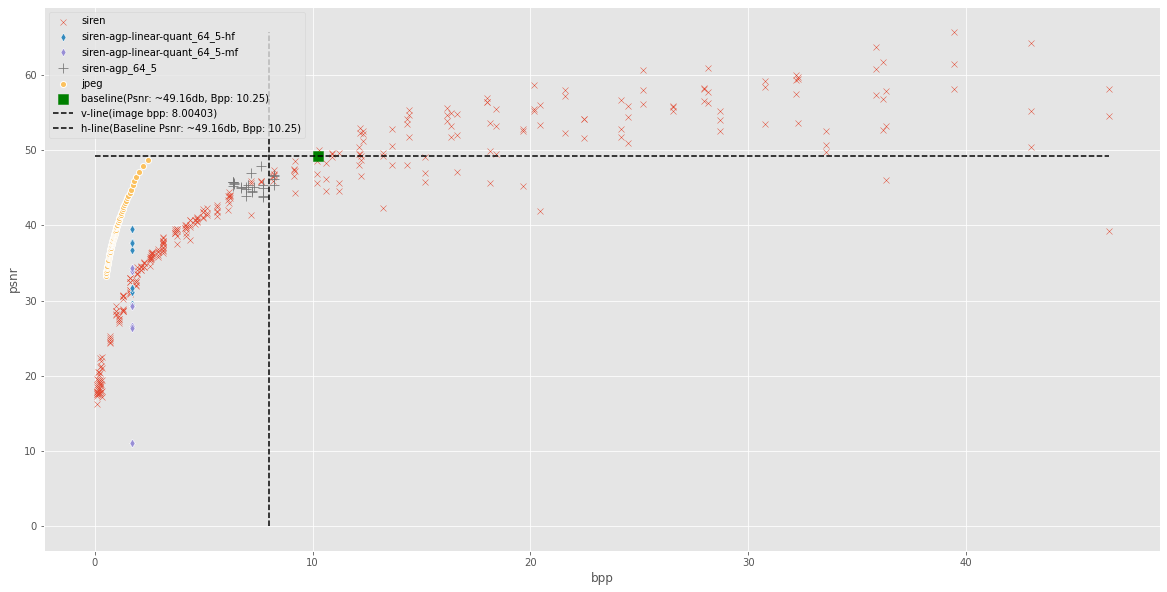

In [26]:
x = 'bpp'; y = "psnr"

fig, axes  = plt.subplots(1, 1, figsize = (20, 10))
sns.scatterplot(data = train_df, x=f"{x}", y=f"{y}", label = 'siren', marker = 'x', ax = axes)
sns.scatterplot(data = siren_quant_aware_df, x=f"{x}", y=f"{y.upper()}", label = 'siren-agp-linear-quant_64_5-hf', marker = 'd', ax = axes)
sns.scatterplot(data = siren_quant_aware_middle_freq_df, x=f"{x}", y=f"{y.upper()}", label = 'siren-agp-linear-quant_64_5-mf', marker = 'd', ax = axes)
sns.scatterplot(data = agp_df, x=f"{x}", y=f"{y}", label = 'siren-agp_64_5', marker = '+', ax = axes, s=100)
sns.scatterplot(data = result_jpeg_df, x=f"{x}", y=f"{y}", label = 'jpeg', marker = '.', ax = axes, s=150)
axes.scatter(10.25, 49.16, label = 'baseline(Psnr: ~49.16db, Bpp: 10.25)', marker = 's', color = 'green', s=100)

data = (train_df[y].values, agp_df[y].values, result_jpeg_df[y].values, siren_quant_aware_df[y.upper()].values)
ymin, ymax = 0, np.max(np.concatenate(data))
axes.vlines(x = 8.00403, ymin = ymin, ymax = ymax, 
           color='k', linestyle='--',
           label = 'v-line(image bpp: 8.00403)')

data = (train_df[x].values, agp_df[x].values, result_jpeg_df[x].values, siren_quant_aware_df[x].values)
xmin, xmax = 0, np.max(np.concatenate(data))
axes.hlines(y = 49.16, xmin = 0, xmax = xmax, 
           color='k', linestyle='--',
           label = 'h-line(Baseline Psnr: ~49.16db, Bpp: 10.25)') 
plt.legend()
plt.show()

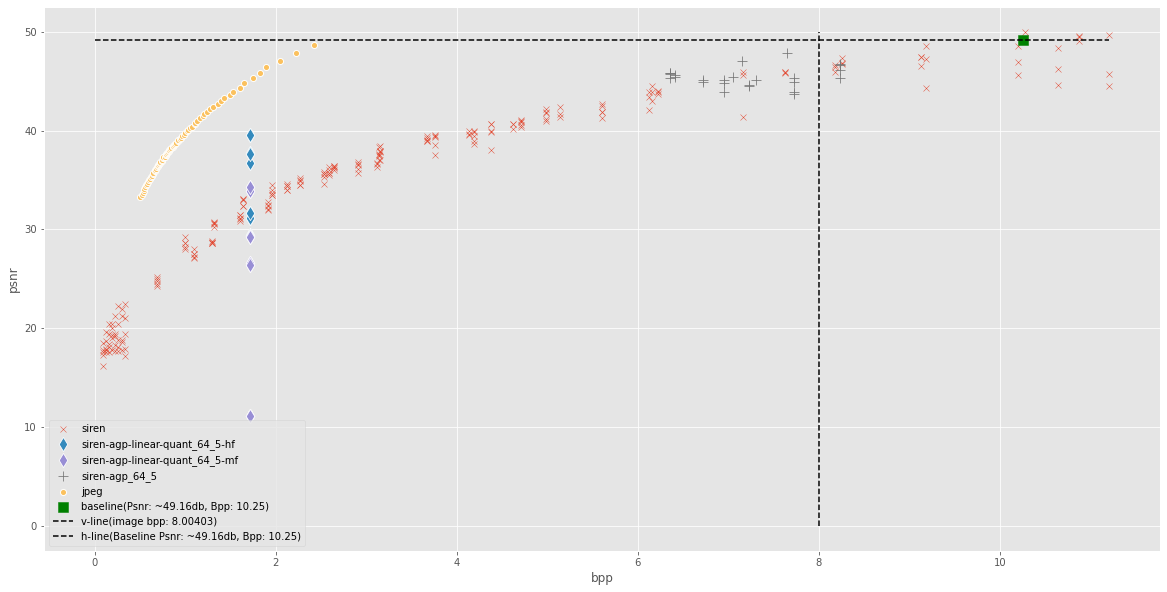

In [27]:
x = 'bpp'; y = "psnr"

train_df_psnr_lower_than_50db = train_df[(train_df["psnr"] <= 50.) & (train_df["bpp"] <= 12.)]

fig, axes  = plt.subplots(1, 1, figsize = (20, 10))
sns.scatterplot(data = train_df_psnr_lower_than_50db, x=f"{x}", y=f"{y}", label = 'siren', marker = 'x', ax = axes)
sns.scatterplot(data = siren_quant_aware_df, x=f"{x}", y=f"{y.upper()}", label = 'siren-agp-linear-quant_64_5-hf', marker = 'd', ax = axes, s=100)
sns.scatterplot(data = siren_quant_aware_middle_freq_df, x=f"{x}", y=f"{y.upper()}", label = 'siren-agp-linear-quant_64_5-mf', marker = 'd', ax = axes, s=100)
sns.scatterplot(data = agp_df, x=f"{x}", y=f"{y}", label = 'siren-agp_64_5', marker = '+', ax = axes, s=100)
sns.scatterplot(data = result_jpeg_df, x=f"{x}", y=f"{y}", label = 'jpeg', marker = '.', ax = axes, s=150)
axes.scatter(10.25, 49.16, label = 'baseline(Psnr: ~49.16db, Bpp: 10.25)', marker = 's', color = 'green', s=100)

data = (train_df_psnr_lower_than_50db[y].values, agp_df[y].values, result_jpeg_df[y].values, siren_quant_aware_df[y.upper()].values)
ymin, ymax = 0, np.max(np.concatenate(data))
axes.vlines(x = 8.00403, ymin = ymin, ymax = ymax, 
           color='k', linestyle='--',
           label = 'v-line(image bpp: 8.00403)')

data = (train_df_psnr_lower_than_50db[x].values, agp_df[x].values, result_jpeg_df[x].values, siren_quant_aware_df[x].values)
xmin, xmax = 0, np.max(np.concatenate(data))
axes.hlines(y = 49.16, xmin = 0, xmax = xmax, 
           color='k', linestyle='--',
           label = 'h-line(Baseline Psnr: ~49.16db, Bpp: 10.25)') 
plt.legend()
plt.show()

In [28]:
attributes_of_stats = ["MSE","PSNR","SSIM", "TIME", "model_size_byte", "bpp"]
attributes_of_groupby = ["QUANT_TECH", "MODE", "PC_WTS"]
siren_quant_aware_df.groupby(by = attributes_of_groupby)[attributes_of_stats].\
    describe().\
T\
.loc[[# ( 'MSE', 'mean'), ('MSE', 'std'), \
      ('PSNR', 'mean'), ('PSNR', 'std'), \
      # ('bpp', 'mean'), ('bpp', 'std'), \
      # ('model_size_byte', 'mean'), ('model_size_byte', 'std'), \
      ('SSIM', 'mean'), ('SSIM', 'std'), \
      ('TIME', 'mean'), ('TIME', 'std')
     ]]

QUANT_TECH QuantAwareTrainRangeLinearQuantizer                                 \
MODE                         ASYMMETRIC_SIGNED            ASYMMETRIC_UNSIGNED   
PC_WTS                                   False      True                False   
PSNR mean                            34.655961  35.353298           33.871893   
     std                              4.215977   5.921815            3.928569   
SSIM mean                             0.921408   0.922692            0.914157   
     std                              0.055609   0.068984            0.049566   
TIME mean                             0.007886   0.007866            0.007921   
     std                              0.000054   0.000129            0.000088   

QUANT_TECH                                   
MODE                   SYMMETRIC             
PC_WTS          True       False      True   
PSNR mean   34.436553  33.871893  34.436553  
     std     4.970855   3.928569   4.970855  
SSIM mean    0.914431   0.914157   0.914431  
     std     0.059149   0.049566   0.059149  
TIME mean    0.007950   0.007826   0.007865  
     std     0.000148   0.000062   0.000059

In [29]:
table = siren_quant_aware_df.groupby(by = attributes_of_groupby)[attributes_of_stats].\
    describe().\
T\
.loc[[# ( 'MSE', 'mean'), ('MSE', 'std'), \
      ('PSNR', 'mean'), ('PSNR', 'std'), \
      # ('bpp', 'mean'), ('bpp', 'std'), \
      # ('model_size_byte', 'mean'), ('model_size_byte', 'std'), \
      ('SSIM', 'mean'), ('SSIM', 'std'), \
      ('TIME', 'mean'), ('TIME', 'std')
     ]]

In [30]:
print(tabulate.tabulate(table, tablefmt="github", headers = table.columns))

|                  |   ('QuantAwareTrainRangeLinearQuantizer', 'ASYMMETRIC_SIGNED', False) |   ('QuantAwareTrainRangeLinearQuantizer', 'ASYMMETRIC_SIGNED', True) |   ('QuantAwareTrainRangeLinearQuantizer', 'ASYMMETRIC_UNSIGNED', False) |   ('QuantAwareTrainRangeLinearQuantizer', 'ASYMMETRIC_UNSIGNED', True) |   ('QuantAwareTrainRangeLinearQuantizer', 'SYMMETRIC', False) |   ('QuantAwareTrainRangeLinearQuantizer', 'SYMMETRIC', True) |
|------------------|-----------------------------------------------------------------------|----------------------------------------------------------------------|-------------------------------------------------------------------------|------------------------------------------------------------------------|---------------------------------------------------------------|--------------------------------------------------------------|
| ('PSNR', 'mean') |                                                          34.656       |                                

|                  |   ('QuantAwareTrainRangeLinearQuantizer', 'ASYMMETRIC_SIGNED', False) |   ('QuantAwareTrainRangeLinearQuantizer', 'ASYMMETRIC_SIGNED', True) |   ('QuantAwareTrainRangeLinearQuantizer', 'ASYMMETRIC_UNSIGNED', False) |   ('QuantAwareTrainRangeLinearQuantizer', 'ASYMMETRIC_UNSIGNED', True) |   ('QuantAwareTrainRangeLinearQuantizer', 'SYMMETRIC', False) |   ('QuantAwareTrainRangeLinearQuantizer', 'SYMMETRIC', True) |
|------------------|-----------------------------------------------------------------------|----------------------------------------------------------------------|-------------------------------------------------------------------------|------------------------------------------------------------------------|---------------------------------------------------------------|--------------------------------------------------------------|
| ('PSNR', 'mean') |                                                          34.656       |                                                         35.3533      |                                                            33.8719      |                                                           34.4366      |                                                  33.8719      |                                                 34.4366      |
| ('PSNR', 'std')  |                                                           4.21598     |                                                          5.92181     |                                                             3.92857     |                                                            4.97086     |                                                   3.92857     |                                                  4.97086     |
| ('SSIM', 'mean') |                                                           0.921408    |                                                          0.922692    |                                                             0.914157    |                                                            0.914431    |                                                   0.914157    |                                                  0.914431    |
| ('SSIM', 'std')  |                                                           0.0556086   |                                                          0.0689844   |                                                             0.049566    |                                                            0.0591493   |                                                   0.049566    |                                                  0.0591493   |
| ('TIME', 'mean') |                                                           0.0078858   |                                                          0.0078663   |                                                             0.00792068  |                                                            0.00794953  |                                                   0.00782637  |                                                  0.00786502  |
| ('TIME', 'std')  |                                                           5.41644e-05 |                                                          0.000128976 |                                                             8.81813e-05 |                                                            0.000148176 |                                                   6.17194e-05 |                                                  5.90453e-05 |